In [1]:
# Allow reload of objects
%load_ext autoreload
%autoreload
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
from scipy.signal import savgol_filter
from tqdm import tqdm

from pelenet.utils import Utils
from pelenet.experiments.readoutrandom import ReadoutRandomExperiment
from pelenet.experiments.readout import ReadoutExperiment

In [2]:
# Initilizes utils
utils = Utils.instance()

In [3]:
# load data
sExRand = np.load('data/comparison/72-pool-neurons/spikes_ex-random.npy')
sOutRand = np.load('data/comparison/72-pool-neurons/spikes_out-random.npy')
sExAniso = np.load('data/comparison/72-pool-neurons/spikes_ex-anisotropic.npy')
sOutAniso = np.load('data/comparison/72-pool-neurons/spikes_out-anisotropic.npy')

In [4]:
# Matplotlib parameters
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['font.family'] = 'CMU Sans Serif'
plt.rcParams['font.size'] = 14

In [5]:
def readParameters():
    exp = ReadoutExperiment()
    return exp.p

p = readParameters()

# Spike trains and firing rates

In [6]:
def concatenateSpikes(data, nTrials, size=p.reservoirExSize):
    spiketrain = np.hstack([np.concatenate((data[i], np.zeros((size,20))), axis=1) for i in range(nTrials)])
    rates = np.mean(spiketrain, axis=0)
    return spiketrain, rates

In [7]:
def plotSpikeTrain(spiketrain, color, name):
    # Define colors
    cmap = colors.ListedColormap(['#ffffff', color])

    # Plot spike train
    plt.figure(figsize=(10,6))
    plt.imshow(spiketrain, cmap=cmap, aspect='auto')
    #plt.title('Reservoir spikes')
    plt.xlabel('time steps')
    plt.ylabel('index of neuron')
    plt.xlim((0,spiketrain.shape[1]))
    plt.savefig('plots/figure5/spiketrain_'+name+'.svg')
    pl = plt.show()

def plotPoolTrain(spiketrain, color, name):
    # Define colors
    cmap = colors.ListedColormap(['#ffffff', color])

    # Plot spike train
    plt.figure(figsize=(10,2))
    plt.imshow(spiketrain, cmap=cmap, aspect='auto')
    #plt.title('Reservoir spikes')
    plt.xlabel('time steps')
    plt.ylabel('index of neuron')
    plt.xlim((0,spiketrain.shape[1]))
    plt.savefig('plots/figure5/spiketrain-pool_'+name+'.svg')
    pl = plt.show()
    
def plotSpikeRates(spikerates, color, name):
    plt.figure(figsize=(10,2))
    plt.plot(spikerates, color=color)
    plt.ylabel('mean firing rate')
    plt.ylim((0,0.25))
    plt.xlabel('time steps')
    plt.xlim((0,len(spikerates)))
    plt.savefig('plots/figure5/spikerates_'+name+'.svg')
    pl = plt.show()

In [8]:
# Reservoir
spiketrainRand, ratesRand = concatenateSpikes(sExRand[:,:,:200], 3)
spiketrainAniso, ratesAniso = concatenateSpikes(sExAniso[:,:,:200], 3)

# Pool
spiketrainOutRand, ratesOutRand = concatenateSpikes(sOutRand[:,:,:200], 3, size=p.numOutputNeurons)
spiketrainOutAniso, ratesOutAniso = concatenateSpikes(sOutAniso[:,:,:200], 3, size=p.numOutputNeurons)

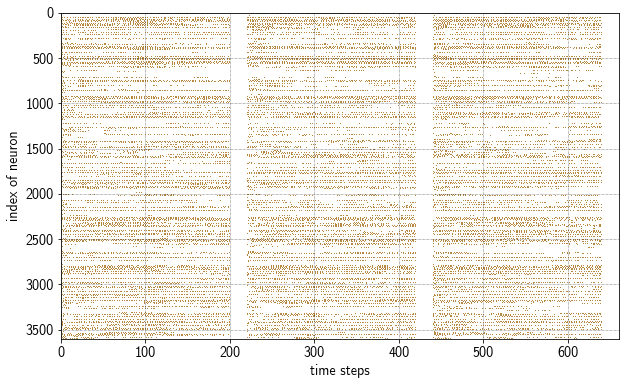

In [9]:
plotSpikeTrain(spiketrainRand, p.pltColor4, 'random')

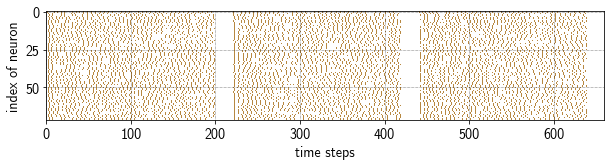

In [10]:
plotPoolTrain(spiketrainOutRand, p.pltColor4, 'random')

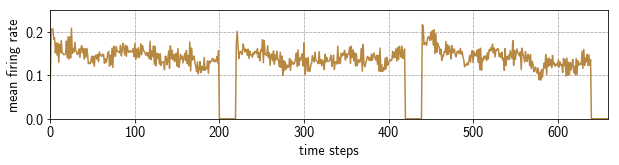

In [11]:
plotSpikeRates(ratesRand, p.pltColor4, 'random')

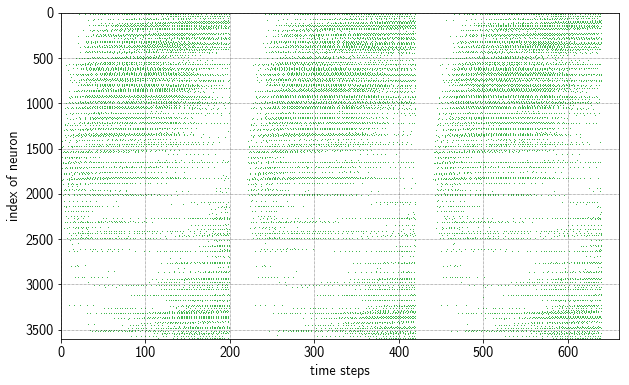

In [12]:
plotSpikeTrain(spiketrainAniso, p.pltColor3, 'anisotropic')

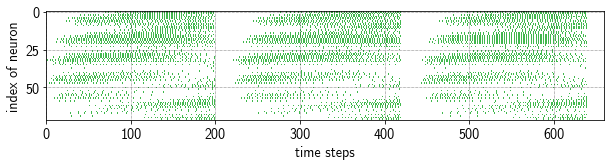

In [13]:
plotPoolTrain(spiketrainOutAniso, p.pltColor3, 'anisotropic')

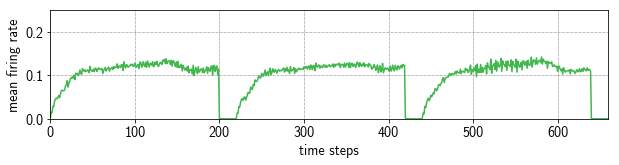

In [14]:
plotSpikeRates(ratesAniso, p.pltColor3, 'anisotropic')

# Distribution of spiking pattern

In [15]:
# Get spiking frequencies of first trial from random network
randFreq = np.mean(sExRand[0,:,:200], axis=1)
randFreq = randFreq[randFreq > 0]

# Get spiking frequencies of first trial from anisotropic network
anisoFreq = np.mean(sExAniso[0,:,:200], axis=1)
anisoFreq = anisoFreq[anisoFreq > 0]

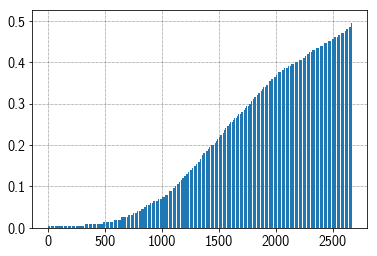

In [16]:
# Sorted neuron firing frequencies for random network
pl = plt.bar(np.arange(len(randFreq)), np.sort(randFreq))

In [17]:
# Compare with uniform distribution
stats.kstest(randFreq, stats.uniform(loc=0.0, scale=100.0).cdf)

KstestResult(statistic=0.995, pvalue=0.0)

In [18]:
# Entropy
stats.entropy(randFreq)

7.463673256654343

<BarContainer object of 2579 artists>

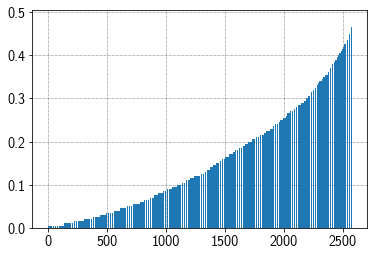

In [19]:
# Sorted neuron firing frequencies for anisotropic network
plt.bar(np.arange(len(anisoFreq)), np.sort(anisoFreq))

In [20]:
# Entropy
stats.entropy(anisoFreq)

7.518203906788838

# Differences between trials

Shows mean difference between trials. The single differences are normed with the number of neurons devided by the refractory period (with 3600 neurons and refractory period of 2, we expect maximum 1800 neurons to be active).

In [21]:
def calcTrialDiffs(data):
    diffs = []
    for i in range(p.trials):
        for j in range(p.trials):
            if i > j:
                # Get difference between data, devide by number of neurons
                err = np.sum(np.abs(data[i] - data[j]), axis=0)
                # Mean over neurons
                #norm = data.shape[1]/p.refractoryDelay
                norm = np.sum(data[i] + data[j], axis=0)
                # Append to list
                diffs.append(err/norm)
    
    # Make numpy array and return
    return np.array(diffs)

In [90]:
def plotDiffMean(diffsRand, diffsAniso, title, ylim=None):
    """
    Random network
    """
    # Calculate mean and standard deviation
    mr = np.mean(np.array(diffsRand), axis=0)
    sr = np.std(np.array(diffsRand), axis=0)
    # Plot mean
    plt.plot(mr, color=p.pltColor4, linewidth=2.0, label='Random')
    # Plot standard deviation around mean
    plt.fill_between(np.arange(210), mr-sr, mr+sr, color=p.pltColor4, alpha=0.5)
    
    """
    Anisotropic network
    """
    # Calculate mean and standard deviation
    ma = np.mean(np.array(diffsAniso), axis=0)
    sa = np.std(np.array(diffsAniso), axis=0)
    # Plot mean
    plt.plot(ma, color=p.pltColor3, linewidth=2.0, label='Anisotropic')
    # Plot standard deviation around mean
    plt.fill_between(np.arange(210), ma-sa, ma+sa, color=p.pltColor3, alpha=0.5)

    #plt.legend()
    plt.xlim(0,200)
    if ylim is not None: plt.ylim(ylim)
    plt.xlabel('time steps')
    plt.ylabel('mean differences between trials')
    plt.title(title)
    # Save and show plot
    plt.savefig('plots/figure5/trialdiffs.svg')
    pl = plt.show()

In [23]:
binSize = 10

def getBinnedSpikesWindow(data):
    return np.array([np.mean(data[:, :, i:i+binSize], axis=2) for i in range(0,data.shape[2],1)])

def getClusteredFrequencies(sm, binSize):
    topologyIndices = np.arange(p.reservoirExSize).reshape((p.topologySize, p.topologySize))
    numBins = int(p.topologySize / binSize)

    smb = []
    for i in range(numBins):
        # Define from and to variables for index i
        ifr, ito = i*binSize, (i+1)*binSize
        for j in range(numBins):
            # Define from and to variables for index j
            jfr, jto = j*binSize, (j+1)*binSize
            # Get topology indices and set connect neurons between output cluster and output neuron
            idc = topologyIndices[ifr:ito,jfr:jto]
            smb.append(np.mean(sm[idc], axis=(0,1)))
    return np.array(smb)

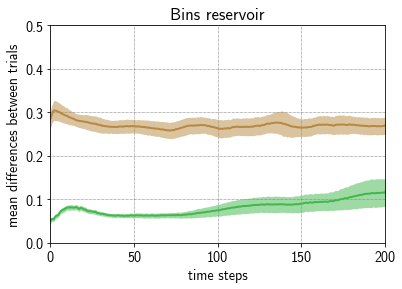

In [91]:
# Bins reservoir
diffsRandBins = calcTrialDiffs(np.moveaxis(getBinnedSpikesWindow(sExRand), 0, 2))
diffsAnisoBins = calcTrialDiffs(np.moveaxis(getBinnedSpikesWindow(sExAniso), 0, 2))
plotDiffMean(diffsRandBins, diffsAnisoBins, title='Bins reservoir', ylim=(0,0.5))

# Spikes reservoir
#diffsRandSpikes = calcTrialDiffs(sExRand)
#diffsAnisoSpikes = calcTrialDiffs(sExAniso)
#plotDiffMean(diffsRandSpikes, diffsAnisoSpikes, title='Spikes reservoir', ylim=(0,0.8))

# Bins grouped
#diffsRand = calcTrialDiffs(np.swapaxes(getBinnedSpikesWindow(sExRandClust), 0, 2))
#diffsAniso = calcTrialDiffs(np.swapaxes(getBinnedSpikesWindow(sExAnisoClust), 0, 2))
#plotDiffMean(diffsRand, diffsAniso, title='Bins grouped', ylim=(0,0.3))

# Spikes grouped
#diffsRand = calcTrialDiffs(np.swapaxes(sExRandClust, 0, 1))
#diffsAniso = calcTrialDiffs(np.swapaxes(sExAnisoClust, 0, 1))
#plotDiffMean(diffsRand, diffsAniso, title='Spikes grouped', ylim=(0,0.3))

In [25]:
stats.mannwhitneyu(np.mean(diffsRandBins, axis=1), np.mean(diffsAnisoBins, axis=1))

MannwhitneyuResult(statistic=0.0, pvalue=5.274820743446428e-100)

In [26]:
# Check normality
stats.shapiro(diffsRandBins[:,120])

(0.9936585426330566, 0.24001652002334595)

In [27]:
# Levene test for random network spikes
stats.levene(diffsRandBins[:,10], diffsRandBins[:,100], diffsRandBins[:,190], center='mean')

LeveneResult(statistic=0.6031668825820727, pvalue=0.5472980957203544)

In [28]:
# Levene test for ansiotropic network spikes
stats.levene(diffsAnisoBins[:,10], diffsAnisoBins[:,100], diffsAnisoBins[:,190], center='mean')

LeveneResult(statistic=208.8727569712581, pvalue=3.3644131325915727e-75)

In [82]:
stats.levene(diffsRandBins[:,10], diffsAnisoBins[:,10], center='mean')

LeveneResult(statistic=248.85921550125934, pvalue=3.9419781494529873e-47)

In [80]:
np.std(diffsRandBins[:,150])

0.02046673813659012

In [81]:
np.std(diffsAnisoBins[:,150])

0.020017069448050116

# Fano factors / coefficient of variation

In [29]:
sExRand_ff = utils.fano(sExRand)
sExAniso_ff = utils.fano(sExAniso)

sExRand_cv = utils.cv(sExRand)
sExAniso_cv = utils.cv(sExAniso)

In [30]:
print(stats.shapiro(sExRand_ff))
print(stats.shapiro(sExAniso_ff))

print(stats.shapiro(sExRand_cv))
print(stats.shapiro(sExAniso_cv))

(0.9705371856689453, 0.6587231159210205)
(0.855637788772583, 0.0022576353512704372)
(0.9481086730957031, 0.2271975576877594)
(0.9811481237411499, 0.9068775773048401)


In [31]:
print(stats.levene(sExRand_ff, sExAniso_ff))
print(stats.levene(sExRand_cv, sExAniso_cv))

LeveneResult(statistic=18.358707582897626, pvalue=8.748549587570188e-05)
LeveneResult(statistic=16.04602271893406, pvalue=0.00021408212091899933)


In [83]:
print("Random: {:.5f} +/- {:.5f}, Anisotropic: {:.5f} +/- {:.5f}".format(np.mean(sExRand_ff), np.std(sExRand_ff), np.mean(sExAniso_ff), np.std(sExAniso_ff)))
print("Random: {:.5f} +/- {:.5f}, Anisotropic: {:.5f} +/- {:.5f}".format(np.mean(sExRand_cv), np.std(sExRand_cv), np.mean(sExAniso_cv), np.std(sExAniso_cv)))

Random: 0.80448 +/- 0.00663, Anisotropic: 0.84454 +/- 0.00199
Random: 4.65274 +/- 0.20603, Anisotropic: 3.85530 +/- 0.05262


In [33]:
# mannwhitneyu networks
print(stats.mannwhitneyu(sExRand_ff, sExAniso_ff))
print(stats.mannwhitneyu(sExRand_cv, sExAniso_cv))

MannwhitneyuResult(statistic=0.0, pvalue=7.078281124247769e-10)
MannwhitneyuResult(statistic=0.0, pvalue=7.078281124247769e-10)


# PCA

In [86]:
# Bin spiking data
binSize = 10

def getBinnedSpikes(data):
    return np.array([np.mean(data[:, :, i:i+binSize], axis=2) for i in range(0,data.shape[2],binSize)])

def pcaAllTrials(bins):
    dtrans = []
    for i in tqdm(range(p.trials)):
        (d, evals, evecs) = utils.pca(bins[:,i,:].astype(float), dims_rescaled_data=2)
        dtrans.append(d)
        
    return np.array(dtrans)

def plotPca1d(pc, color, name):
    for i in range(p.trials):
        plt.plot(np.arange(0,p.stepsPerTrial,binSize), pc[i,:,0], linewidth=0.5, color=color)
    plt.xlabel('time steps')
    plt.savefig('plots/figure5/pca1d_'+name+'.svg')
    pl = plt.show()

def plotPca2d(pc, color, name):
    #plt.figure(figsize=(10,4))
    plt.figure(figsize=(8,6))
    ax = plt.axes(projection='3d')
    for i in range(p.trials):
        ax.plot3D(np.arange(0,p.stepsPerTrial,binSize), pc[i,:,0], pc[i,:,1], linewidth=0.5, color=color)
    ax.view_init(20,285)
    #ax.set_yticks([])
    #ax.set_zticks([])
    plt.xlim(0,200)
    ax.yaxis.set_ticklabels([])
    ax.zaxis.set_ticklabels([])
    #ax.set_xlabel('time steps', labelpad=40)
    ax.set_xlabel('time steps', labelpad=20)
    ax.set_ylabel('PC1', labelpad=-5)
    ax.set_zlabel('PC2', labelpad=-5)
    #ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1, 0.5, 0.8, 1]))  # scale_x, scale_y, scale_z, 1
    ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1, 0.8, 0.8, 1]))  # scale_x, scale_y, scale_z, 1
    plt.savefig('plots/figure5/pca2d_'+name+'.svg')
    pl = plt.show()

In [35]:
# Calculate bins
bExRand = getBinnedSpikes(sExRand)
bExAniso = getBinnedSpikes(sExAniso)

In [36]:
# Get first two pca components
p2ExRand = pcaAllTrials(bExRand)
p2ExAniso = pcaAllTrials(bExAniso)

100%|██████████| 25/25 [02:55<00:00,  7.01s/it]


In [37]:
p2ExRand.shape

(25, 21, 2)

In [104]:
np.abs(np.max([p2ExRand[0,:,0], p2ExRand[1,:,0]]) - np.min([p2ExRand[0,:,0], p2ExRand[1,:,0]]))

9.088719106449194

In [105]:
np.abs(np.max([p2ExAniso[0,:,0], p2ExAniso[1,:,0]]) - np.min([p2ExAniso[0,:,0], p2ExAniso[1,:,0]]))

14.303721050214767

In [103]:
# Mean MSE between trajectories
steps = p2ExRand.shape[0]
msesRand = []
msesAniso = []
for i in range(steps):
    for j in range(steps):
        if (i > j):
            mseRand = np.mean(np.square(p2ExRand[i,:,0] - p2ExRand[j,:,0]))
            normRand = np.abs(np.max([p2ExRand[i,:,0], p2ExRand[j,:,0]]) - np.min([p2ExRand[i,:,0], p2ExRand[j,:,0]]))
            msesRand.append(mseRand/normRand)
            mseAniso = np.mean(np.square(p2ExAniso[i,:,0] - p2ExAniso[j,:,0]))
            normAniso = np.abs(np.max([p2ExAniso[i,:,0], p2ExAniso[j,:,0]]) - np.min([p2ExAniso[i,:,0], p2ExAniso[j,:,0]]))
            msesAniso.append(mseAniso/normAniso)

print(np.mean(msesRand))
print(np.mean(msesAniso))

print(stats.mannwhitneyu(msesRand, msesAniso))

1.6675422995236084
0.028538414918422714
MannwhitneyuResult(statistic=3572.0, pvalue=4.268747233048057e-85)


In [102]:
# Mean standard deviation between trajectories
p1ExRandStd = np.std(p2ExRand[:,:,0], axis=0)
p1ExAnisoStd = np.std(p2ExAniso[:,:,0], axis=0)

print(np.mean(p1ExRandStd))
print(np.mean(p1ExAnisoStd))

print(stats.mannwhitneyu(p1ExRandStd, p1ExAnisoStd))

2.5003547240620803
0.40568501795769374
MannwhitneyuResult(statistic=0.0, pvalue=1.562699999200436e-08)


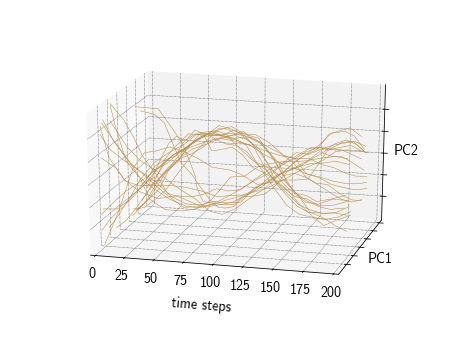

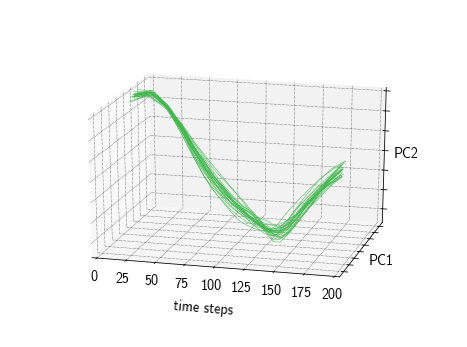

In [87]:
plotPca2d(p2ExRand, p.pltColor4, 'random')
plotPca2d(p2ExAniso, p.pltColor3, 'anisotropic')

In [41]:
stats.fligner(p2ExRand[:,1,0], p2ExRand[:,10,0], p2ExRand[:,19,0])

FlignerResult(statistic=21.15522125419046, pvalue=2.5480155432680344e-05)

In [42]:
stats.fligner(p2ExAniso[:,1,0], p2ExAniso[:,10,0], p2ExAniso[:,19,0])

FlignerResult(statistic=1.8831567624907952, pvalue=0.3900117620364509)

# Multiple trajectories output learning

* 0 Random - Representation - Reservoir
* 1 Random - Representation - Pool 
* 2 Random - Generalisation - Reservoir
* 3 Random - Generalisation - Pool
* 4 Anisotropic - Representation - Reservoir
* 5 Anisotropic - Representation - Pool 
* 6 Anisotropic - Generalisation - Reservoir
* 7 Anisotropic - Generalisation - Pool

In [43]:
"""
Read targets
"""
filePath = 'data/robot2/hide_rec_dmp.txt'
targets = np.loadtxt(filePath)

files = [
    'hide_rec_dmp.txt',
    'move_up_rec_dmp.txt',
    'put_on_top_rec_dmp.txt',
    'unhide_rec_dmp.txt',
    'move_down_rec.txt',
    'pick_and_place_rec_dmp.txt',
    'take_down_rec_dmp.txt'
]

targets = np.array([ np.loadtxt('data/robot2/'+file)[-200:,0:3] for file in files ])
targets = np.moveaxis(targets, 1, 2)

In [44]:
estimates = np.load('data/estimates/estimates_pool72.npy').item()

#estimates = {}

"""
Random network
"""

# Representation Reservoir
#estimates['randRepRes'] = utils.estimateMultipleTrajectories3D(sExRand, targets, trainTrials=np.repeat(True, p.trials))
# Representation Pool
#estimates['randRepPoo'] = utils.estimateMultipleTrajectories3D(sOutRand, targets, trainTrials=np.repeat(True, p.trials))
# Generalisation Reservoir
#estimates['randGenRes'] = utils.estimateMultipleTrajectories3D(sExRand, targets, alpha=0.001, L1_wt=0.05)
# Generalisation Pool
#estimates['randGenPoo'] = utils.estimateMultipleTrajectories3D(sOutRand, targets)

"""
Anisotropic network
"""

# Representation Reservoir
#estimates['anisoRepRes'] = utils.estimateMultipleTrajectories3D(sExAniso, targets, trainTrials=np.repeat(True, p.trials))
# Representation Pool
#estimates['anisoRepPoo'] = utils.estimateMultipleTrajectories3D(sOutAniso, targets, trainTrials=np.repeat(True, p.trials))
# Generalisation Reservoir
#estimates['anisoGenRes'] = utils.estimateMultipleTrajectories3D(sExAniso, targets, alpha=0.001, L1_wt=0.05)
# Generalisation Pool
#estimates['anisoGenPoo'] = utils.estimateMultipleTrajectories3D(sOutAniso, targets)

100%|██████████| 7/7 [00:00<00:00, 17.77it/s]


In [45]:
#np.save('data/estimates/estimates_pool72.npy', estimates)

In [183]:
"""
Find optimal parameters for elastic net regularization
"""
#reservoir/generalisation alpha 0.001, l1wt 0.05
#(x, xe, y) = utils.prepareDataset(sExAniso, tgt)
#for alpha in np.arange(0.0,0.01,0.001):
#    for l1wt in np.arange(0.0,0.125,0.025):
#        x1 = utils.estimateMovement(x, xe, y[0], alpha=alpha, L1_wt=l1wt)
#        print('alpha: {}, l1_wt: {}'.format(alpha, l1wt))
#        plotMovement1D(tgt[0], x1, p.pltColor3, 'x', '')#, ylim=(0.3,0.42))

'\nFind optimal parameters for elastic net regularization\n'

In [46]:
class OOMFormatter(matplotlib.ticker.ScalarFormatter):
    def __init__(self, order=0, fformat="%1.1f", offset=True, mathText=True):
        self.oom = order
        self.fformat = fformat
        matplotlib.ticker.ScalarFormatter.__init__(self,useOffset=offset,useMathText=mathText)
    def _set_orderOfMagnitude(self, nothing=None):
        self.orderOfMagnitude = self.oom
    def _set_format(self, vmin=None, vmax=None):
        self.format = self.fformat
        if self._useMathText:
            self.format = '$%s$' % matplotlib.ticker._mathdefault(self.format)

def calcNRMSE(estimates):
    err = []
    # Iterate over all trajectories
    for i in range(targets.shape[0]):
        # Iterate over all 3 dimensions
        nrmses = []
        for j in range(3):
            # Calculate mean squared error
            #mse = np.max(np.abs(estimates[i,j] - targets[i,j]))  # Lmax
            mse = np.mean(np.square(estimates[i,j] - targets[i,j]))  # L2
            #mse = np.mean(np.abs(estimates[i,j] - targets[i,j]))  # L1
            # Square root mse
            rmse = np.sqrt(mse)
            # Normalise rmse
            #nrmse = rmse/np.abs(np.mean(targets[i,j]))
            nrmse = rmse/np.abs(np.max(targets[i,j]) - np.min(targets[i,j]))
            #nrmses.append(nrmse)
            err.append(nrmse)
            
        #err.append(np.mean(nrmses))
    return err

def plotRMSE(randVals, anisoVals, randYerr, anisoYerr, title):
    barWidth = 1
    
    plt.figure(figsize=(6,2.5))
    
    plt.bar([1,3.5], randVals, yerr=randYerr, width=barWidth, label='Random', color='#b78841', error_kw=dict(lw=1, capthick=1, capsize=4))
    plt.bar([2,4.5], anisoVals, yerr=anisoYerr, width=barWidth, label='Anisotropic', color='#41b74d', error_kw=dict(lw=1, capthick=1, capsize=4))
    
    plt.grid(axis='x')
    #plt.xticks(inds, labels)
    plt.xticks([1.5, 4], ['Reservoir', 'Pool'])
    #plt.yscale('log')
    plt.title(title)
    #plt.ylabel('Normalized root mean squared error')
    plt.ylabel('error')
    #plt.legend()
    name = ''.join(title.split()).lower()
    plt.savefig('plots/figure6/trajectory-error_'+name+'.svg')
    pl = plt.show()
    
def plotRMSE2(vals, yerr, title, xtick, ylim=None, sci=False):
    barWidth = 1
    
    plt.figure(figsize=(3,3))
    ax = plt.gca()
    
    plt.bar([1], vals[0], yerr=yerr[0], width=barWidth, label='Random', color='#b78841', error_kw=dict(lw=1, capthick=1, capsize=4))
    plt.bar([2], vals[1], yerr=yerr[1], width=barWidth, label='Anisotropic', color='#41b74d', error_kw=dict(lw=1, capthick=1, capsize=4))
    
    plt.grid(axis='x')
    #plt.xticks(inds, labels)
    #plt.xticks([1.5, 4], ['Reservoir', 'Pool'])
    plt.xticks([1.5], [xtick])
    #plt.yscale('log')
    #plt.title(title)
    plt.xlim((0,3))
    if ylim is not None: plt.ylim(ylim)
    #plt.ylabel('Normalized root mean squared error')
    plt.ylabel('error')
    #plt.legend()
    if sci: ax.yaxis.set_major_formatter(OOMFormatter(9, "%1.1f"))
    if sci: plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    
    name1 = ''.join(title.split()).lower()
    name2 = ''.join(xtick.split()).lower()
    plt.savefig('plots/figure6/trajectory-error_'+name1+'_'+name2+'.svg')
    pl = plt.show()
    
def printTtest(mse, key1, key2):
    pval = stats.ttest_ind(mse[key1], mse[key2])[1]
    print("{} vs. {}: p = {:.10f}".format(key1, key2, pval))
    

In [47]:
mse = {}
mseMean = {}
mseStd = {}

for key, est in estimates.items():
    mse[key] = calcNRMSE(est)
    mseMean[key] = np.mean(mse[key])
    mseStd[key] = np.std(mse[key])

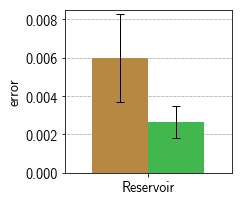

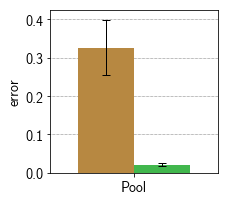

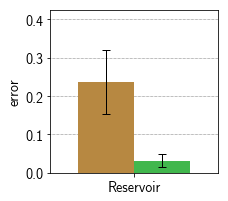

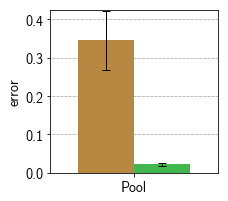

In [48]:
vals = np.array([mseMean['randRepRes'], mseMean['anisoRepRes']])
yerr = np.array([mseStd['randRepRes'], mseStd['anisoRepRes']])

plotRMSE2(vals, yerr, 'Representation', 'Reservoir', ylim=(0,0.0085))

vals = np.array([mseMean['randRepPoo'], mseMean['anisoRepPoo']])
yerr = np.array([mseStd['randRepPoo'], mseStd['anisoRepPoo']])

plotRMSE2(vals, yerr, 'Representation', 'Pool', ylim=(0,0.425))

vals = np.array([mseMean['randGenRes'], mseMean['anisoGenRes']])
yerr = np.array([mseStd['randGenRes'], mseStd['anisoGenRes']])

plotRMSE2(vals, yerr, 'Generalisation', 'Reservoir', ylim=(0,0.425))#, sci=True)

vals = np.array([mseMean['randGenPoo'], mseMean['anisoGenPoo']])
yerr = np.array([mseStd['randGenPoo'], mseStd['anisoGenPoo']])

plotRMSE2(vals, yerr, 'Generalisation', 'Pool', ylim=(0,0.425))

In [49]:
# Compare generalisation/random: reservoir vs. pool
print(stats.shapiro(mse['randGenRes']))  # Normal
print(stats.shapiro(mse['randGenPoo']))  # Normal
print(stats.ttest_ind(mse['randGenRes'], mse['randGenPoo']))  # reservoir is better than pool
print(stats.levene(mse['randGenRes'], mse['randGenPoo']))  # variances are the same

(0.9225116968154907, 0.09742017835378647)
(0.9400579333305359, 0.21848106384277344)
Ttest_indResult(statistic=-4.238171002398469, pvalue=0.00012889801258342121)
LeveneResult(statistic=0.01777084222490762, pvalue=0.8946187537232317)


In [71]:
# Compare generalisation/anisotropic: reservoir vs. pool
print('Reservoir mse: {:.5f}, Pool mse: {:.5f}'.format(np.mean(mse['anisoGenRes']), np.mean(mse['anisoGenPoo'])))
print(stats.shapiro(mse['anisoGenRes']))  # Not normal (one outlier)
print(stats.shapiro(mse['anisoGenPoo']))  # Normal
print(stats.mannwhitneyu(mse['anisoGenRes'], mse['anisoGenPoo']))  # pool is better than reservoir
print(stats.fligner(mse['anisoGenRes'], mse['anisoGenPoo']))  # variances are the same

Reservoir mse: 0.03147, Pool mse: 0.02214
(0.38817209005355835, 2.2023218804179123e-08)
(0.870871901512146, 0.009934484958648682)
MannwhitneyuResult(statistic=47.0, pvalue=6.746815774713781e-06)
FlignerResult(statistic=0.6222590757350214, pvalue=0.4302090361252079)


<BarContainer object of 2 artists>

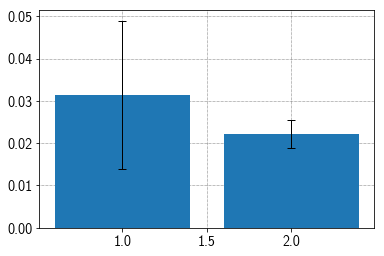

In [69]:
plt.bar([1,2], [np.mean(mse['anisoGenRes']), np.mean(mse['anisoGenPoo'])],
        yerr=[np.std(mse['anisoGenRes']), np.std(mse['anisoGenPoo'])],
        error_kw=dict(lw=1, capthick=1, capsize=4))

randRepRes vs. anisoRepRes: p = 0.0000002957
randRepPoo vs. anisoRepPoo: p = 0.0000000000


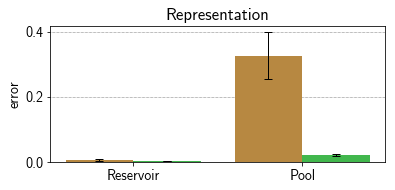

In [51]:
printTtest(mse, 'randRepRes', 'anisoRepRes')
printTtest(mse, 'randRepPoo', 'anisoRepPoo')

vals1 = np.array([mseMean['randRepRes'], mseMean['randRepPoo']])
vals2 = np.array([mseMean['anisoRepRes'], mseMean['anisoRepPoo']])
yerr1 = np.array([mseStd['randRepRes'], mseStd['randRepPoo']])
yerr2 = np.array([mseStd['anisoRepRes'], mseStd['anisoRepPoo']])

plotRMSE(vals1, vals2, yerr1, yerr2, 'Representation')

randGenRes vs. anisoGenRes: p = 0.0000000000
randGenPoo vs. anisoGenPoo: p = 0.0000000000


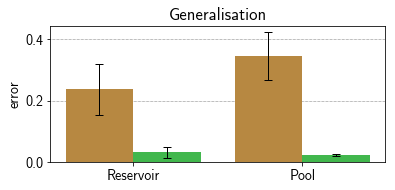

In [52]:
printTtest(mse, 'randGenRes', 'anisoGenRes')
printTtest(mse, 'randGenPoo', 'anisoGenPoo')

vals1 = np.array([mseMean['randGenRes'], mseMean['randGenPoo']])
vals2 = np.array([mseMean['anisoGenRes'], mseMean['anisoGenPoo']])
yerr1 = np.array([mseStd['randGenRes'], mseStd['randGenPoo']])
yerr2 = np.array([mseStd['anisoGenRes'], mseStd['anisoGenPoo']])

plotRMSE(vals1, vals2, yerr1, yerr2, 'Generalisation')

# Generalisation pool

In [53]:
idxT = 0  # choose an index of a trajectory

est = estimates['anisoGenPoo'][idxT]
tgt = targets[idxT]

In [54]:
def getTicks(limits, precision=20):
    # Calc upper and bottom ticks
    b = float(np.ceil(limits[0]*precision)/precision)
    t = float(np.floor(limits[1]*precision)/precision)+0.0000001

    # Arange ticks and return
    return np.arange(b, t, float(1/precision))

def plotMovement1D(tgt, est, color, dim, name, ylim=None):
    plt.figure(figsize=(6,2))
    plt.plot(tgt, linewidth=4.0, color='#D500F9', label='target trajectory')
    plt.plot(est, linewidth=2.0, color=color, alpha=0.9, label='network output')
    plt.plot(savgol_filter(est, 21, 1), alpha=0.9, linewidth=2.0, linestyle='dotted', color='#000000', label='smoothed output')
    plt.xlim(0, len(tgt))
    if ylim is not None: plt.ylim(ylim)
    plt.xlabel('time steps')
    plt.ylabel(dim+' [m]')
    plt.savefig('plots/figure6/'+name+'-1d-'+dim+'.svg')
    pl = plt.show()
    
def plotMovement3D(tgt, est, color, name, view=(20, 120), xlim=None, ylim=None, zlim=None):
    plt.figure(figsize=(10,8))
    ax = plt.axes(projection='3d')
    ax.plot3D(tgt[0], tgt[1], tgt[2], linewidth=4.0, color='#D500F9')
    ax.plot3D(est[0], est[1], est[2], linewidth=2.0, color=color, alpha=0.8)
    ax.plot3D(
        savgol_filter(est[0], 21, 1), savgol_filter(est[1], 21, 1), savgol_filter(est[2], 21, 1),
        linewidth=2.0, linestyle='dotted', color='#000000', alpha=0.9
    )
    
    # Set axis and limits if limits are given
    if xlim is not None:
        ax.set_xticks(getTicks(xlim, precision=40))
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_yticks(getTicks(ylim, precision=40))
        ax.set_ylim(ylim)
    if zlim is not None:
        ax.set_zticks(getTicks(zlim, precision=20))
        ax.set_zlim(zlim)
        
    # Set view perspective
    ax.view_init(*view)
    
    # Set labels
    ax.set_xlabel('x [m]', labelpad=10)
    ax.set_ylabel('y [m]', labelpad=10)
    ax.set_zlabel('z [m]', labelpad=10)
    
    plt.savefig('plots/figure6/'+name+'-3d.svg')
    pl = plt.show()

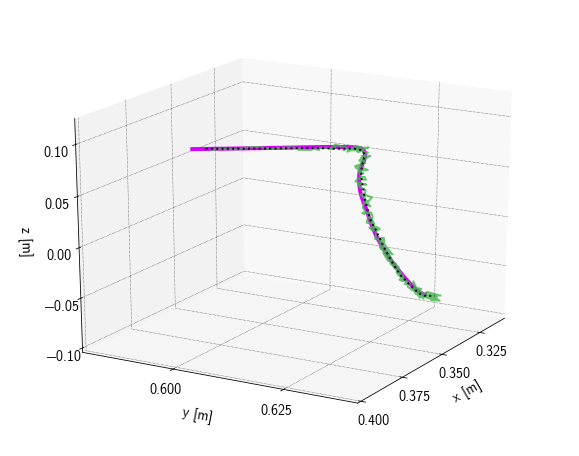

In [55]:
plotMovement3D(tgt, est, p.pltColor3, 'generalisation-aniso-pool',
               view=(20, 30), xlim=(0.31,0.4), ylim=(0.58,0.64), zlim=(-0.1,0.12))

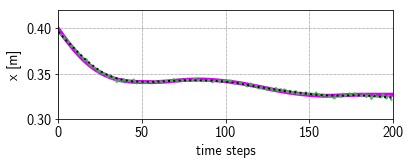

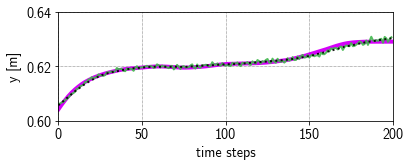

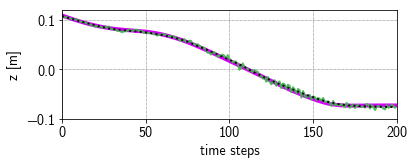

In [56]:
plotMovement1D(tgt[0], est[0], p.pltColor3, 'x', 'generalisation-aniso-pool', ylim=(0.3,0.42))
plotMovement1D(tgt[1], est[1], p.pltColor3, 'y', 'generalisation-aniso-pool', ylim=(0.6,0.64))
plotMovement1D(tgt[2], est[2], p.pltColor3, 'z', 'generalisation-aniso-pool', ylim=(-0.1,0.12))

# All cases

In [57]:
idxT = 0  # choose an index of a trajectory

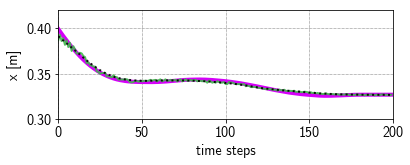

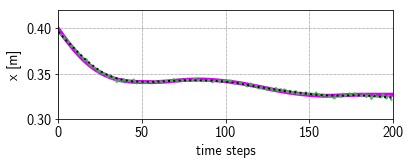

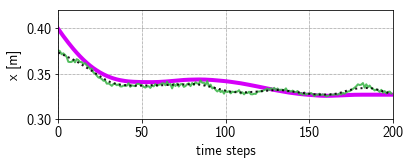

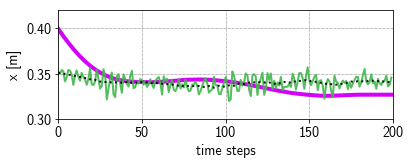

In [58]:
"""
Generalisation
"""

# Generalisation / Anisotropic / Reservoir
plotMovement1D(targets[idxT][0], estimates['anisoGenRes'][idxT][0], p.pltColor3, 'x', 'generalisation-aniso-reservoir', ylim=(0.3,0.42))
# Generalisation / Anisotropic / Pool
# Already produced, see above
plotMovement1D(targets[idxT][0], estimates['anisoGenPoo'][idxT][0], p.pltColor3, 'x', 'generalisation-aniso-pool', ylim=(0.3,0.42))
# Generalisation / Random / Reservoir
plotMovement1D(targets[idxT][0], estimates['randGenRes'][idxT][0], p.pltColor3, 'x', 'generalisation-random-reservoir', ylim=(0.3,0.42))
# Generalisation / Random / Pool
plotMovement1D(targets[idxT][0], estimates['randGenPoo'][idxT][0], p.pltColor3, 'x', 'generalisation-random-pool', ylim=(0.3,0.42))

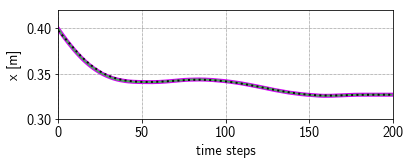

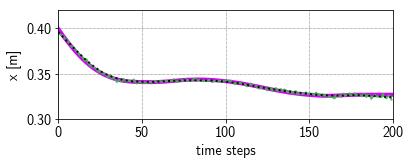

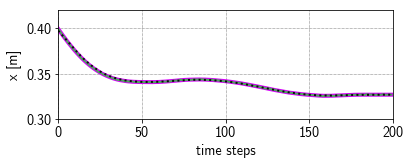

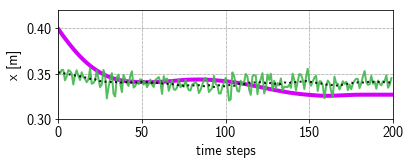

In [59]:
"""
Representation
"""

# Representation / Anisotropic / Reservoir
plotMovement1D(targets[idxT][0], estimates['anisoRepRes'][idxT][0], p.pltColor3, 'x', 'representation-aniso-reservoir', ylim=(0.3,0.42))

# Representation / Anisotropic / Pool
plotMovement1D(targets[idxT][0], estimates['anisoRepPoo'][idxT][0], p.pltColor3, 'x', 'representation-aniso-pool', ylim=(0.3,0.42))

# Representation / Random / Reservoir
plotMovement1D(targets[idxT][0], estimates['randRepRes'][idxT][0], p.pltColor3, 'x', 'representation-random-reservoir', ylim=(0.3,0.42))

# Representation / Random / Pool
plotMovement1D(targets[idxT][0], estimates['randRepPoo'][idxT][0], p.pltColor3, 'x', 'representation-random-pool', ylim=(0.3,0.42))